In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12d_cgan.ipynb"
_nb_title = "Conditional GANs"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Conditional+GANs&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F12_generation%2F12d_cgan.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/12_generation/12d_cgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 条件付き敵対的生成ネットワーク(cGAN)
MNISTを利用して、シンプルなcGANと畳み込み層を使用したcGANの学習を行います。

## 実行環境
このノートブックは、TPU上でもGPU上でも実行可能です。

Vertex AI WorkbenchやColabでGPUやTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import os, shutil
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

2022-12-14 16:59:04.242372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 16:59:04.242424: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 16:59:06.390273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 16:59:06.390319: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 16:59:06.390342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-direct): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-14 16:59:06.544194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 16:59:06.563816: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-14 16:59:06.563852: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:34108}
2022-12-14 16:59:06.759228: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-14 16:59:06.759278: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:34108}
2022-1

INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np

## 定数

In [4]:
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
LATENT_DIM = 512

## cGAN

生成器と識別機の両方にDenseレイヤーのみを使用したシンプルなcGANを作成します。

条件付きでないGANと比較して、ラベルが入力に含められていることに注目してください。

In [5]:
# Create the generator.
def create_label_vectors(
    labels, num_classes, embedding_dim, dense_units
):
    """Creates label vectors from label indices.

    Args:
        labels: tensor, rank 1 tensor of labels with shape (batch_size,).
        num_classes: int, the number of image classes.
        embedding_dim: int, the embedding's output dimension.
        dense_units: int, the number of units for `Dense` layer.

    Returns:
        label_vectors: tensor, rank 2 tensor of shape
            (batch_size, dense_units).
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    label_vectors = tf.keras.layers.Dense(
        units=dense_units
    )(inputs=embedded_labels)

    return label_vectors

def standard_vanilla_generator(inputs, output_shape):
    """Returns output of standard vanilla generator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).
        output_shape: tuple, the shape of the output without batch dimension.

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = tf.keras.layers.Dense(units=64)(inputs=inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(
        units=output_shape[0] * output_shape[1] * output_shape[2],
        activation="tanh"
    )(inputs=x)

    outputs = tf.keras.layers.Reshape(target_shape=output_shape)(inputs=x)

    return outputs

def create_vanilla_generator(latent_dim, num_classes, output_shape):
    """Creates vanilla conditional GAN generator model.

    Args:
        latent_dim: int, the latent vector dimension length.
        num_classes: int, the number of image classes.
        output_shape: tuple, the shape of the output without batch dimension.

    Returns:
        Keras Functional Model.
    """
    latent_vector = tf.keras.Input(shape=(latent_dim,))

    labels = tf.keras.Input(shape=())
    label_vectors = create_label_vectors(
        labels, num_classes, embedding_dim=50, dense_units=50
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_vector, label_vectors])
    
    outputs = standard_vanilla_generator(
        inputs=concatenated_inputs, output_shape=output_shape
    )

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="vanilla_generator"
    )

with strategy.scope():
    vanilla_generator = create_vanilla_generator(
        latent_dim=LATENT_DIM, num_classes=NUM_CLASSES, output_shape=IMAGE_SHAPE
    )
vanilla_generator.summary()

Model: "vanilla_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50)           500         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 50)           2550        ['embedding[0][0]']              
                                                                                  

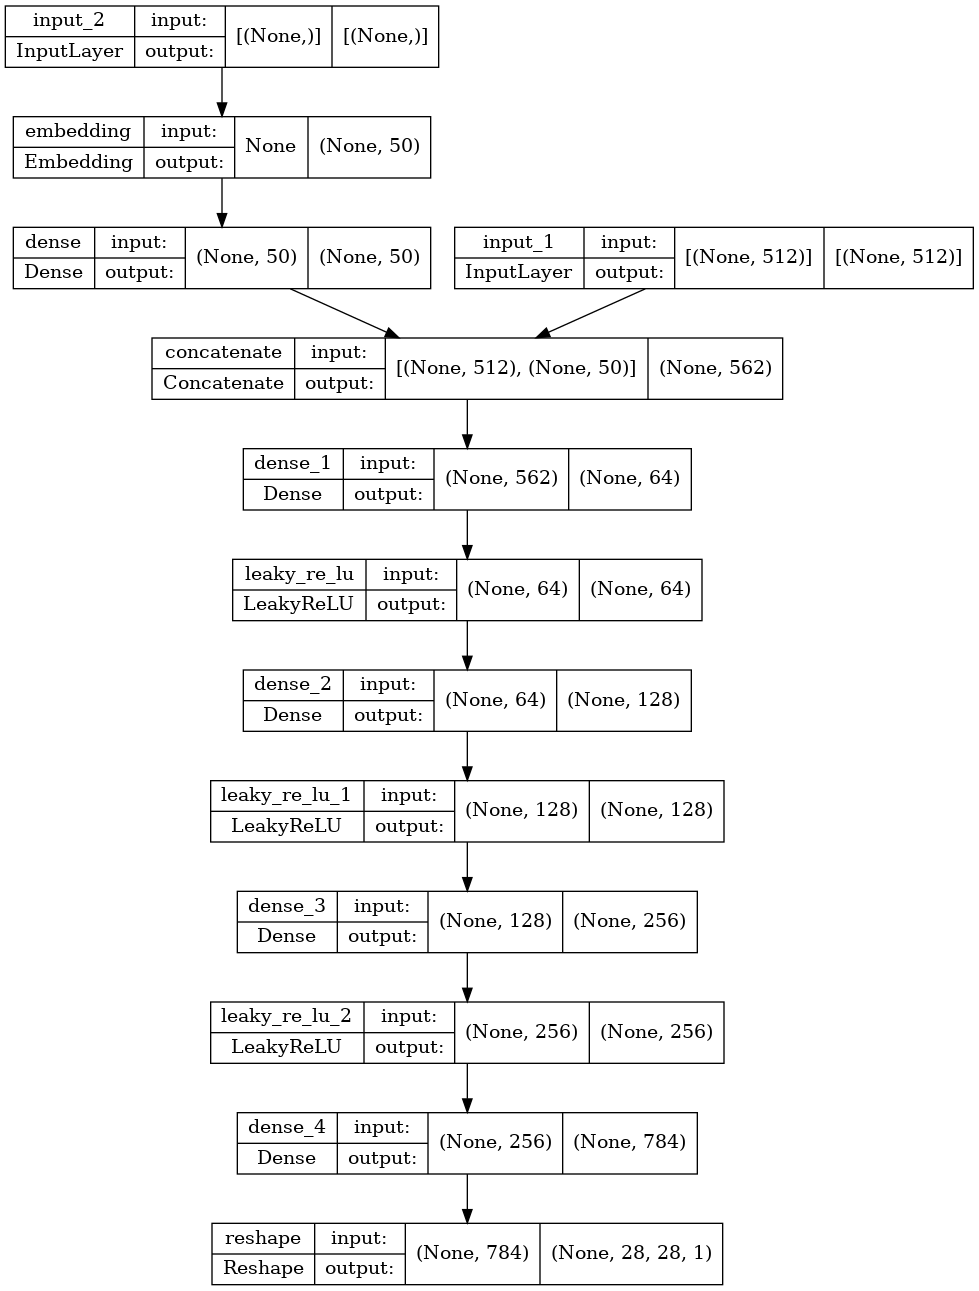

In [6]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="conditional_vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [7]:
# Create the discriminator.
def create_label_images(
    labels, num_classes, embedding_dim, image_shape
):
    """Creates label images from label indices.

    Args:
        labels: tensor, rank 1 tensor of labels with shape (batch_size,).
        num_classes: int, the number of image classes.
        embedding_dim: int, the embedding's output dimension.
        image_shape: tuple, the shape of the image without batch dimension.

    Returns:
        label_image: tensor, rank 4 tensor of shape
            (batch_size, height, width, 1).
    """
    embedded_labels = tf.keras.layers.Embedding(
        input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    num_pixels = image_shape[0] * image_shape[1]
    dense_labels = tf.keras.layers.Dense(
        units=num_pixels
    )(inputs=embedded_labels)
    label_image = tf.keras.layers.Reshape(
        target_shape=(image_shape[0], image_shape[1], 1)
    )(inputs=dense_labels)

    return label_image

def standard_vanilla_discriminator(inputs):
    """Returns output of standard vanilla discriminator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = tf.keras.layers.Flatten()(inputs=inputs)
    x = tf.keras.layers.Dense(units=256)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=128)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)
    x = tf.keras.layers.Dense(units=64)(inputs=x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(inputs=x)

    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_vanilla_discriminator(image_shape, num_classes):
    """Creates vanilla conditional GAN discriminator model.

    Args:
        image_shape: tuple, the shape of the image without batch dimension.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels, num_classes, embedding_dim=50, image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_vanilla_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="vanilla_discriminator"
    )

with strategy.scope():
    vanilla_discriminator = create_vanilla_discriminator(
        image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
    )
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50)           500         ['input_4[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 784)          39984       ['embedding_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                              

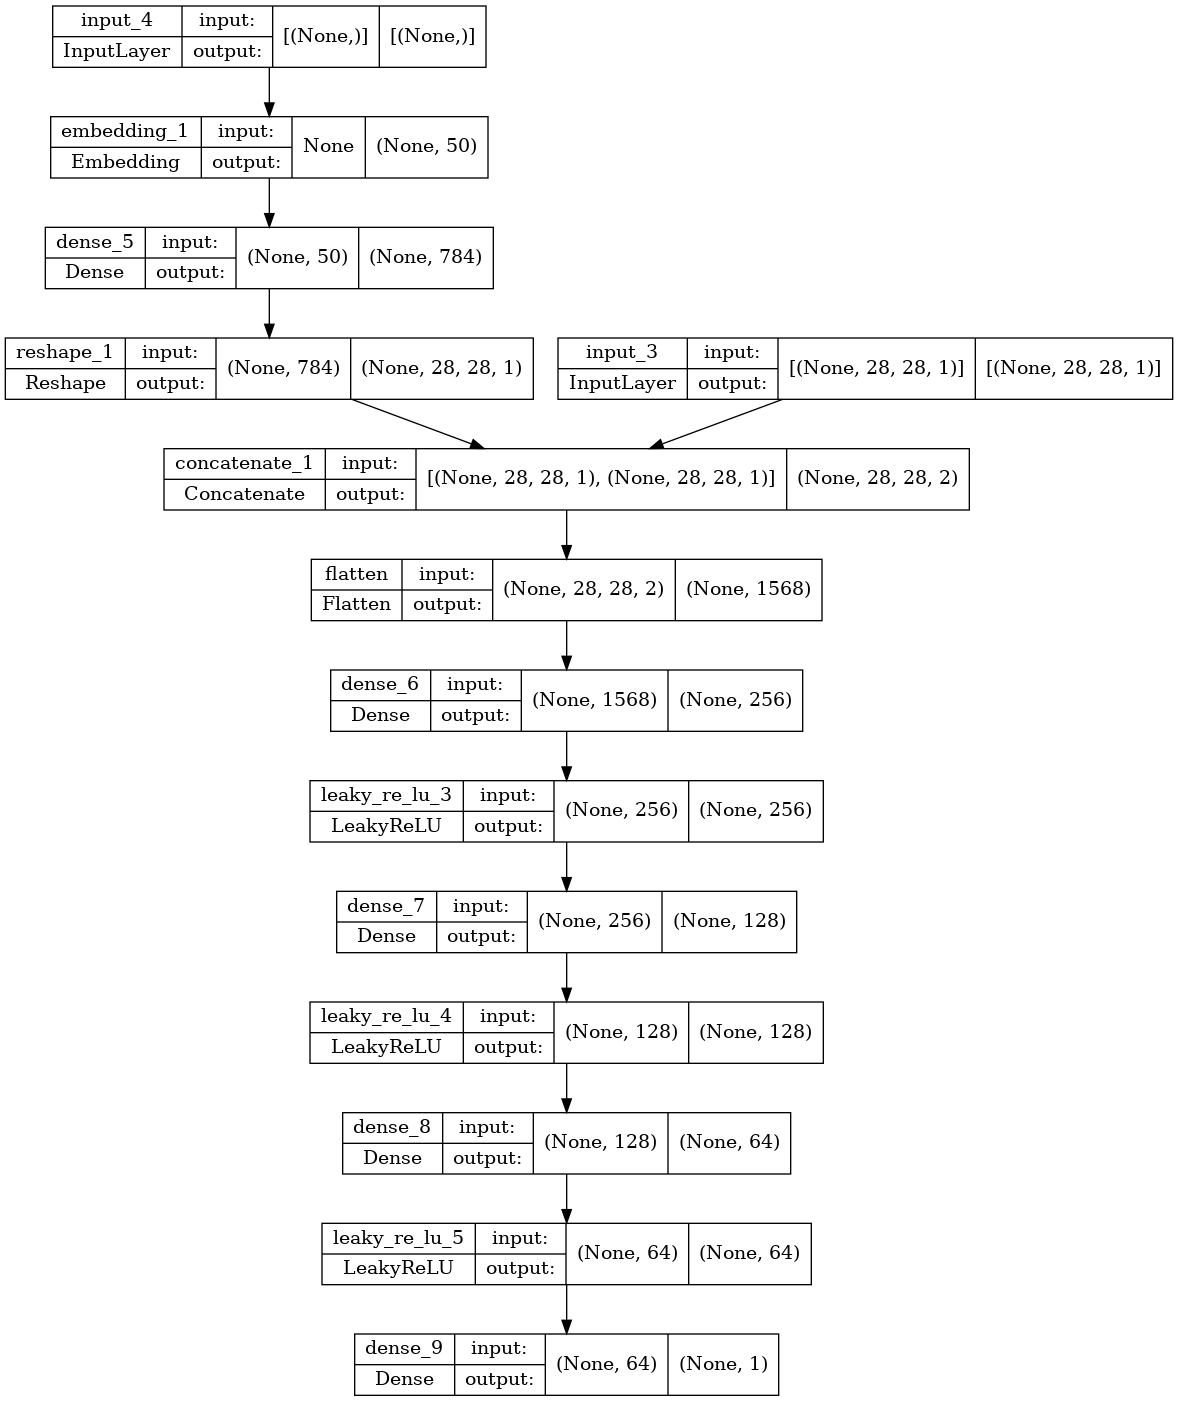

In [8]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="conditional_vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

ジェネレーターとディスクリミネーターネットワークのトレーニングを容易にするために使用できる `GAN`という名前のカスタム` Model`クラスを作成します。

In [9]:
class GAN(tf.keras.Model):
    """Custom model for training a GAN.

    Attributes:
        discriminator: Keras `Model`, the discriminator network.
        generator: Keras `Model`, the generator network.
        latent_dim: int, the latent vector dimension length.
        one_sided_label_smoothing: float, how much to smooth the real image
            labels by value in [0., 1.].
        discriminator_optimizer: Keras `Optimizer`, optimizer for
            discriminator network.
        generator_optimizer: Keras `Optimizer`, optimizer for generator
            network.
        loss_fn: Keras `Loss`, loss function for training both networks.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """Instantiates `GAN` model class.

        Args:
            discriminator: Keras `Model`, the discriminator network.
            generator: Keras `Model`, the generator network.
            latent_dim: int, the latent vector dimension length.
            one_sided_label_smoothing: float, how much to smooth the real image
                labels by value in [0., 1.].
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn, steps_per_execution):
        """Overrides base `Model` class' compile method.

        Args:
            discriminator_optimizer: Keras `Optimizer`, optimizer for
                discriminator network.
            generator_optimizer: Keras `Optimizer`, optimizer for generator
                network.
            loss_fn: Keras `Loss`, loss function for training both networks.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        self._configure_steps_per_execution(steps_per_execution or 1)


    def discriminator_train_step(self, batch_size, real_images, input_labels):
        """Trains discriminator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            discriminator_loss: tensor, scalar loss of disriminator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(
            inputs=[random_latent_vectors, input_labels]
        )

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=[
                    combined_images,
                    tf.concat(values=[input_labels, input_labels], axis=0)
                ]
            )
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size, input_labels):
        """Trains generator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            generator_loss: tensor, scalar loss of generator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            fake_images = self.generator(
                inputs=[random_latent_vectors, input_labels]
            )
            predictions = self.discriminator(
                inputs=[fake_images, input_labels]
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, features):
        """Trains `GAN` for one step.

        Args:
            features: dict, images key has rank 4 tensor of real images with
                shape (batch_size, height, width, depth) for value and labels
                key has rank 1 tensor of labels with shape (batch_size,).

        Returns:
            losses: dict, dictionary of losses from each sub-training step.
        """
        real_images = features["images"]
        input_labels = features["labels"]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = tf.reduce_sum(self.discriminator_train_step(
            batch_size, real_images, input_labels
        )) * tf.cast((1 / batch_size), tf.float32)

        # Then train generator.
        generator_loss = tf.reduce_sum(self.generator_train_step(
            batch_size, input_labels
        )) * tf.cast((1 / batch_size), tf.float32)

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [10]:
def create_train_dataset(batch_size):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined_images = np.concatenate([x_train, x_test])
    combined_images = (combined_images.astype("float32") - 127.5) / 255.0
    combined_images = np.reshape(combined_images, newshape=(-1, 28, 28, 1))

    combined_labels = np.concatenate([y_train, y_test])

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(
        tensors={"images": combined_images, "labels": combined_labels}
    )
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size, drop_remainder=True).cache()

    return dataset


In [11]:
# Instantiate a GAN instance using our vanilla generator and discriminator.

with strategy.scope():
    vanilla_gan = GAN(
        discriminator=vanilla_discriminator,
        generator=vanilla_generator,
        latent_dim=LATENT_DIM,
        one_sided_label_smoothing=0.9
    )

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    steps_per_execution=64 if type(strategy) == tf.distribute.TPUStrategy else 1
)

# Train vanilla GAN model.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128), epochs=30
)

Epoch 1/30
546/546 [==============================] - 11s 21ms/step - discriminator_loss: 1.1380 - generator_loss: 1.8286
Epoch 2/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.0602 - generator_loss: 1.5011
Epoch 3/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.0796 - generator_loss: 1.3485
Epoch 4/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.1312 - generator_loss: 1.5000
Epoch 5/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.1021 - generator_loss: 1.4045
Epoch 6/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.1582 - generator_loss: 1.3715
Epoch 7/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.1777 - generator_loss: 1.4630
Epoch 8/30
546/546 [==============================] - 2s 4ms/step - discriminator_loss: 1.2073 - generator_loss: 1.1544
Epoch 9/30
546/546 [==================

損失の履歴を確認した後、学習済み済みモデルを使用して生成された画像をプロットしてみましょう。

In [12]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [13]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

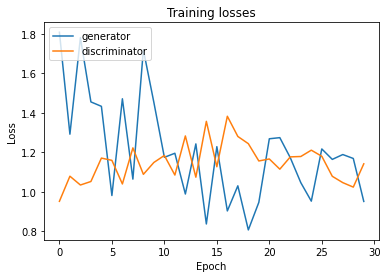

In [14]:
plot_loss_history(history=vanilla_gan_history)

ここでは、生成する数字の種類を制御できることに注目してください。

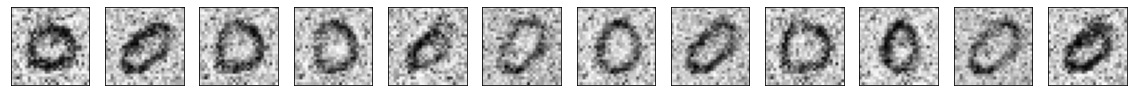

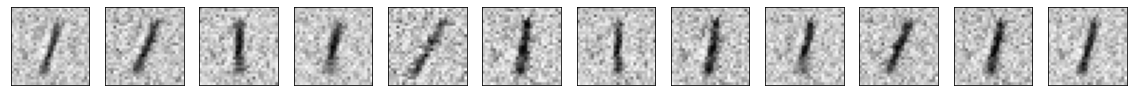

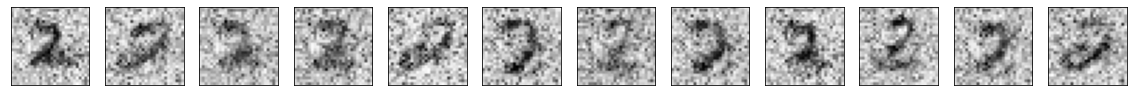

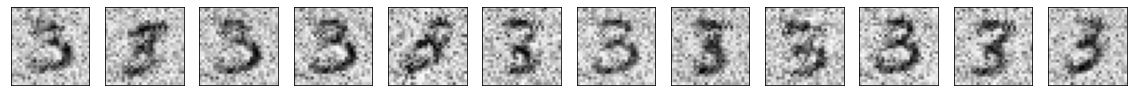

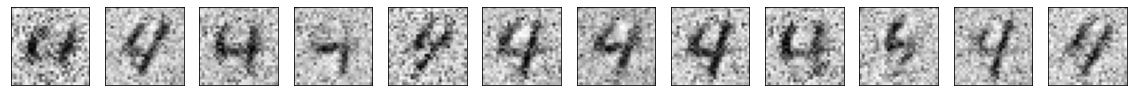

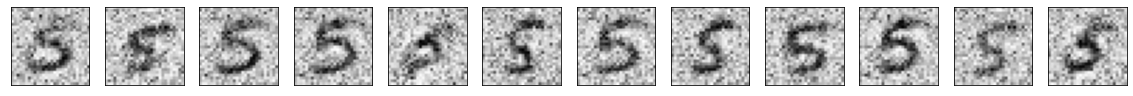

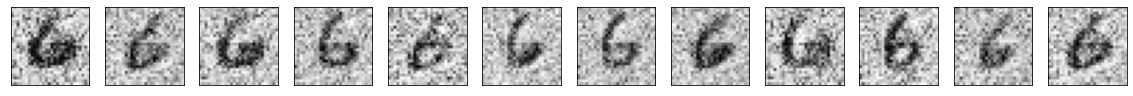

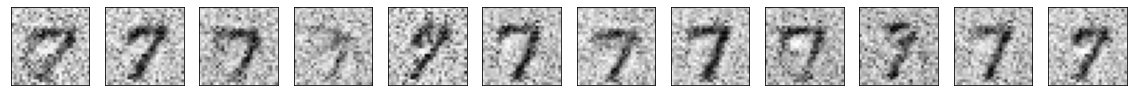

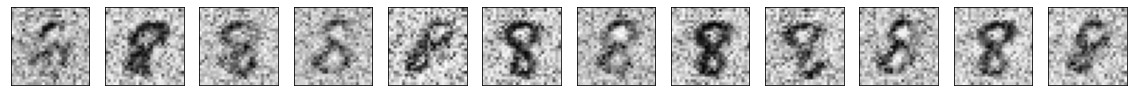

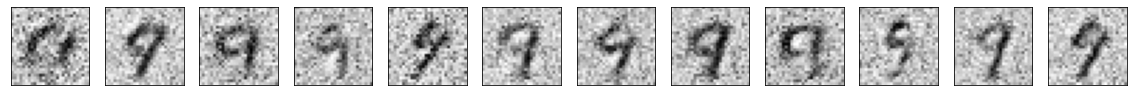

In [15]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=vanilla_gan.generator(
            inputs=[latent_vectors, labels]
        )
    )

## Deep Convolutional cGAN

Deep Convolutional cGANは、識別機と生成器にそれぞれ `Dense`レイヤーの代わりに畳み込み(`Conv2D`)とデコンボリューション( `Conv2DTranspose`)を使用します。

In [16]:
# Create the generator
def project_latent_vector(latent_vector, projection_shape):
    """Projects latent vector into an image.

    Args:
        latent_vector: tensor, rank 2 tensor of labels with shape
            (batch_size, latent_dim).
        projection_shape: 3-tuple, the shape to project vector into an image.

    Returns:
        latent_image: tensor, rank 4 tensor of shape
            (
                batch_size,
                projection_shape[0],
                projection_shape[1],
                projection_shape[2]
            ).
    """
    projected_latents = tf.keras.layers.Dense(
        units=projection_shape[0] * projection_shape[1] * projection_shape[2]
    )(inputs=latent_vector)
    projected_latents = tf.keras.layers.BatchNormalization()(projected_latents)
    projected_latents = tf.keras.layers.LeakyReLU(
        alpha=0.2
    )(inputs=projected_latents)
    latent_image = tf.keras.layers.Reshape(
        target_shape=projection_shape
    )(inputs=projected_latents)

    return latent_image

def create_generator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates generator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height * 2, width * 2, filters).
    """
    x = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_generator(inputs):
    """Returns output of standard DCGAN generator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = create_generator_block(
        inputs=inputs,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_generator_block(
        inputs=x,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2
    )

    outputs = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding="same", activation="tanh"
    )(inputs=x)

    return outputs

def create_dcgan_generator(latent_dim, num_classes):
    """Creates deep convolutional conditional GAN generator model.

    Args:
        latent_dim: int, the latent vector dimension length.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    projection_shape = (7, 7, 64)

    latent_vector = tf.keras.Input(shape=(latent_dim,))
    latent_image = project_latent_vector(latent_vector, projection_shape)
    
    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=projection_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[latent_image, label_image])

    outputs = standard_DCGAN_generator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[latent_vector, labels],
        outputs=outputs,
        name="dcgan_generator"
    )

with strategy.scope():
    dcgan_generator = create_dcgan_generator(
        latent_dim=LATENT_DIM, num_classes=NUM_CLASSES
    )
dcgan_generator.summary()

Model: "dcgan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 3136)         1608768     ['input_5[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 3136)        12544       ['dense_10[0][0]']               
 alization)                                                                         

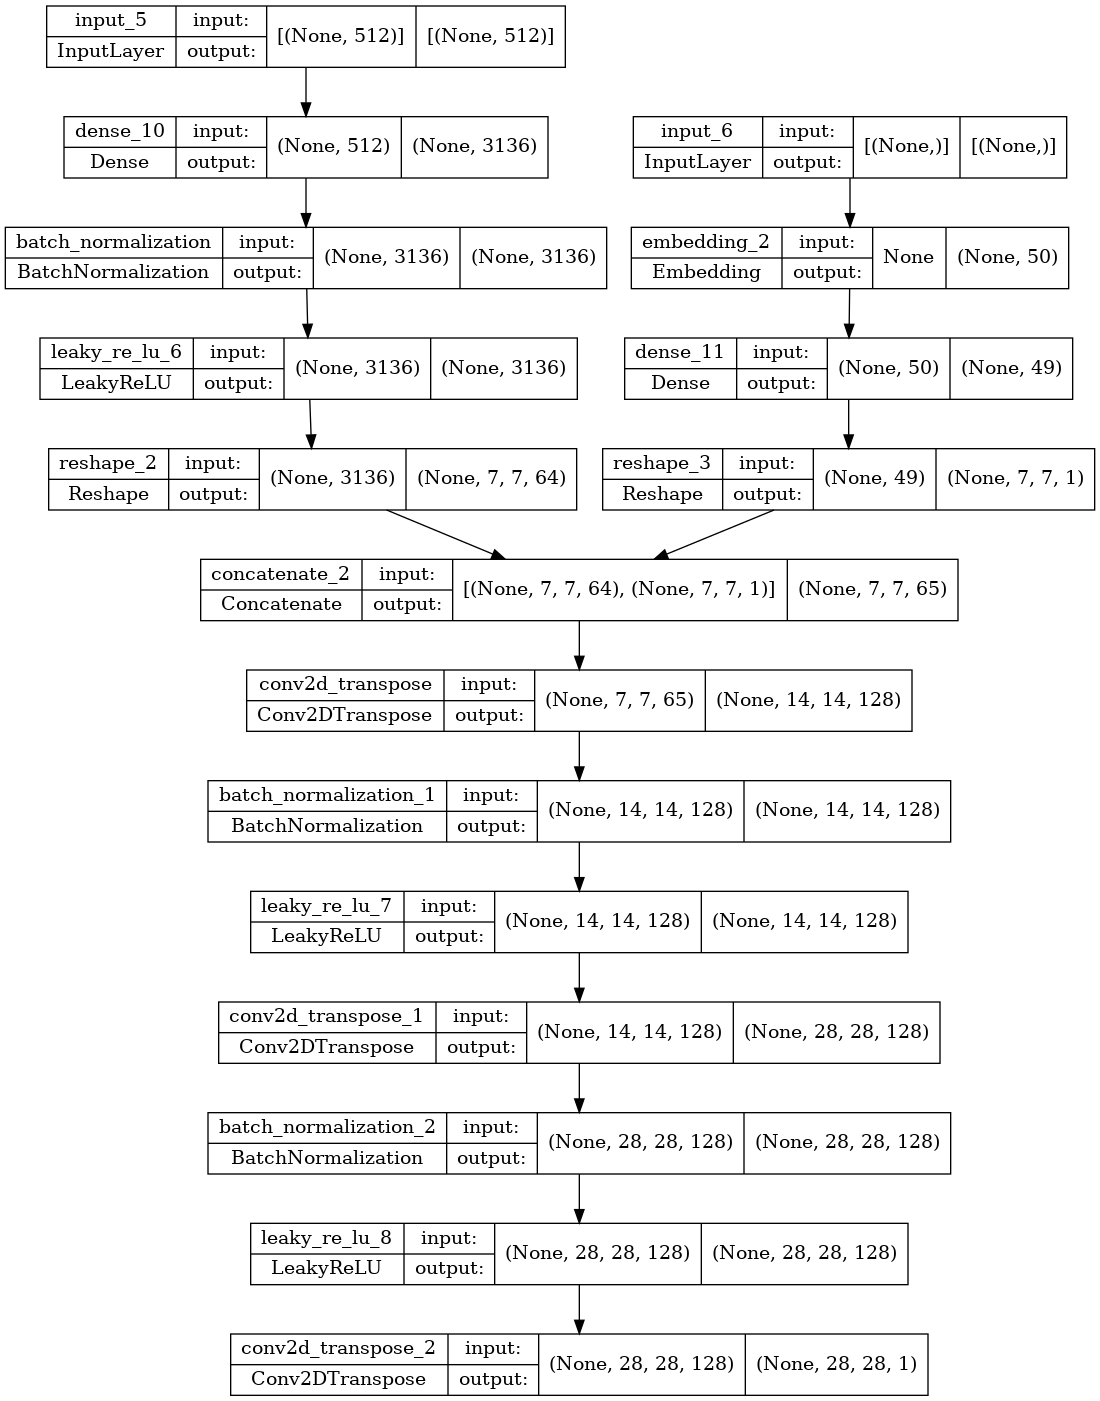

In [17]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="conditional_dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [18]:
# Create the discriminator
def create_discriminator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates discriminator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height // 2, width // 2, filters).
    """
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

def standard_DCGAN_discriminator(inputs):
    """Returns output of standard DCGAN discriminator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 2 tensor of shape (batch_size, 1).
    """
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding="same"
    )(inputs=inputs)

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = create_discriminator_block(
        inputs=x,
        filters=256,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2
    )

    x = tf.keras.layers.Flatten()(inputs=x)
    outputs = tf.keras.layers.Dense(units=1)(inputs=x)

    return outputs

def create_dcgan_discriminator(image_shape, num_classes):
    """Creates deep convolutional conditional GAN discriminator model.

    Args:
        image_shape: tuple, the shape of the image without batch dimension.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    images = tf.keras.Input(shape=image_shape)

    labels = tf.keras.Input(shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=image_shape
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        axis=-1
    )(inputs=[images, label_image])

    outputs = standard_DCGAN_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels],
        outputs=outputs,
        name="dcgan_discriminator"
    )

with strategy.scope():
    dcgan_discriminator = create_dcgan_discriminator(
        image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
    )
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50)           500         ['input_8[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 784)          39984       ['embedding_3[0][0]']            
                                                                                                  
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                

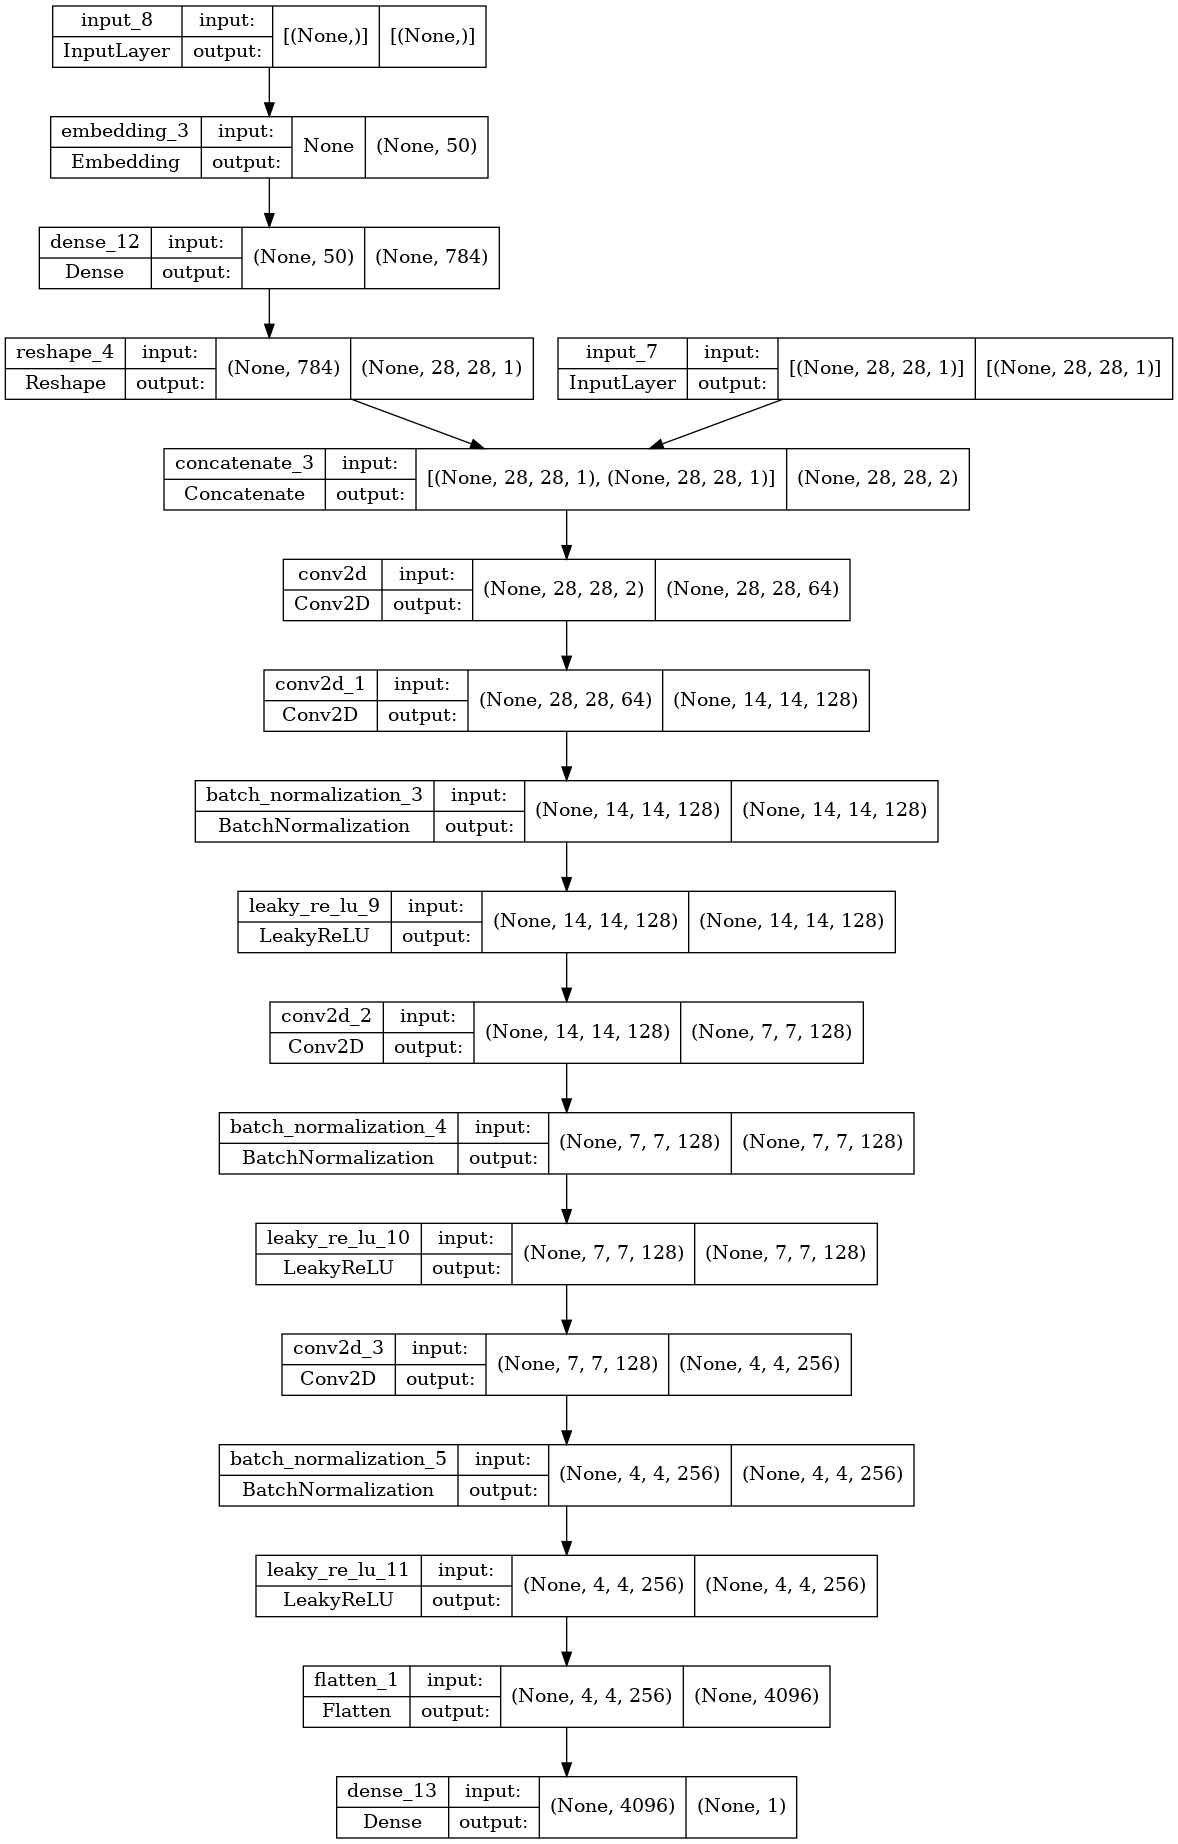

In [19]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="conditional_dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [20]:
# Instantiate a GAN instance using our DCGAN generator and discriminator.
with strategy.scope():
    dcgan = GAN(
        discriminator=dcgan_discriminator,
        generator=dcgan_generator,
        latent_dim=LATENT_DIM,
        one_sided_label_smoothing=0.9
    )

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.00002, beta_1=0.9, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    steps_per_execution=64 if type(strategy) == tf.distribute.TPUStrategy else 1
)

# Train DCGAN model.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128), epochs=50)

Epoch 1/50
546/546 [==============================] - 22s 41ms/step - discriminator_loss: 1.0648 - generator_loss: 1.3408
Epoch 2/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.3840 - generator_loss: 0.8117
Epoch 3/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.3866 - generator_loss: 0.8061
Epoch 4/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.3509 - generator_loss: 0.8223
Epoch 5/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.3183 - generator_loss: 0.8131
Epoch 6/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.1635 - generator_loss: 0.9941
Epoch 7/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.0895 - generator_loss: 1.0425
Epoch 8/50
546/546 [==============================] - 4s 8ms/step - discriminator_loss: 1.2127 - generator_loss: 1.0020
Epoch 9/50
546/546 [==================

同様に、結果のプロットをしてみましょう。

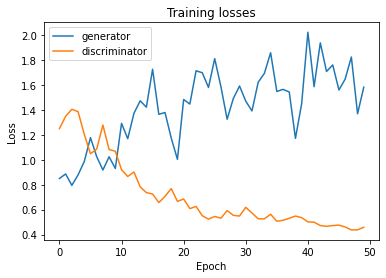

In [21]:
plot_loss_history(history=dcgan_history)

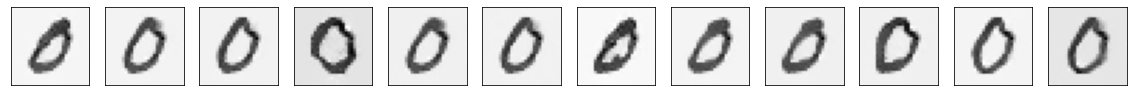

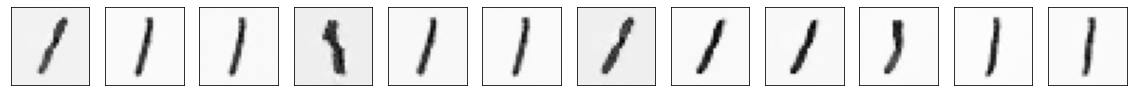

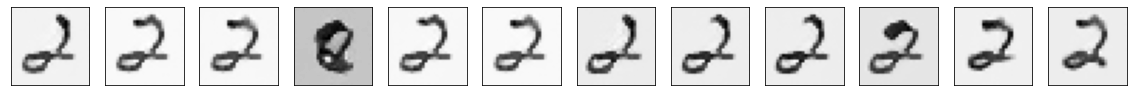

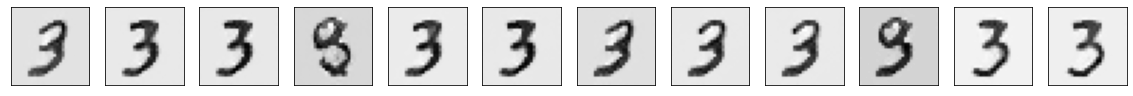

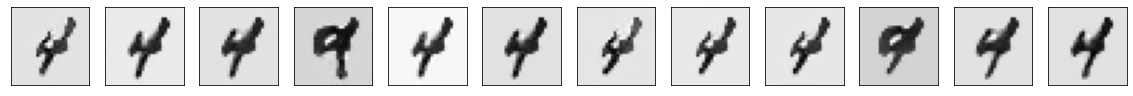

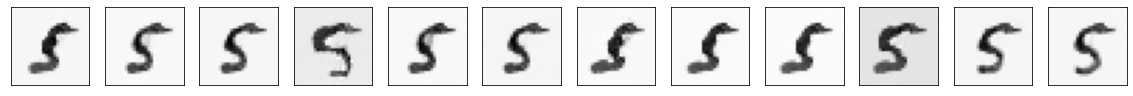

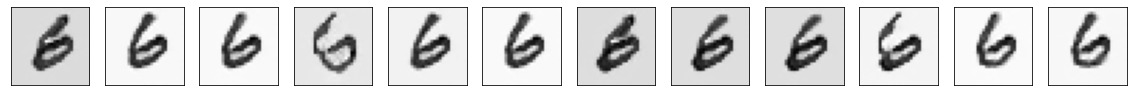

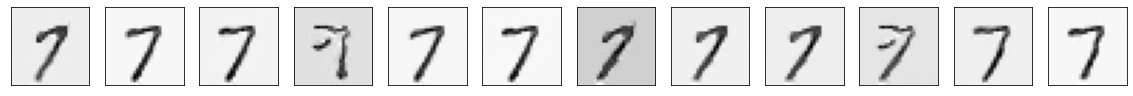

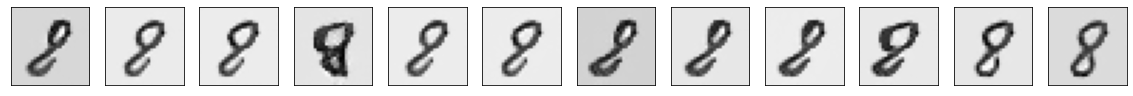

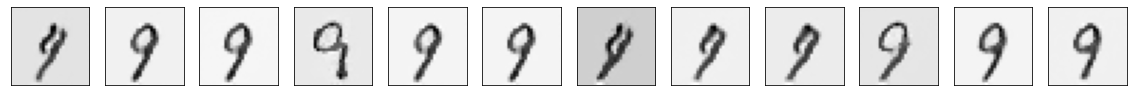

In [22]:
num_examples = 12
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(
        images=dcgan.generator(
            inputs=[latent_vectors, labels]
        )
    )

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.